# Importing Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from matplotlib import pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join

# Function to Create a new dataframe

In [2]:
def create_empty_df():
    df = pd.DataFrame()
    df['area'] = None
    df['perimeter'] = None
    df['red_mean'] = None
    df['green_mean'] = None
    df['blue_mean'] = None
    df['f1'] = None
    df['f2'] = None
    df['red_std'] = None
    df['green_std'] = None
    df['blue_std'] = None
    df['f4'] = None
    df['f5'] = None
    df['f6'] = None
    df['f7'] = None
    df['f8'] = None
    df['label'] = None
    return df

# Function to extract the features

In [3]:
def feature_extractor(filename):
    '''
    input params: 
    filename : path of the file that we want to process

    Output params:
    l : Feature vector
    '''

    try:
        main_img = cv2.imread(filename)
        img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    except:
        return "Invalid"

    #Preprocessing
    

    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((25,25),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

    #Shape features
    contours, _ = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    M = cv2.moments(cnt)
    area = cv2.contourArea(cnt)
    if area==0:
        return "Invalid"
    perimeter = cv2.arcLength(cnt,True)

    current_frame = main_img
    filtered_image = closing/255

    #Elementwise Multiplication of range bounded filtered_image with current_frame
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 0], filtered_image) #B channel
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 1], filtered_image) #G channel
    current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2] = np.multiply(current_frame[0:current_frame.shape[0], 0:current_frame.shape[1], 2], filtered_image) #R channel

    img = current_frame


    #Color features
    red_channel = img[:,:,0]
    green_channel = img[:,:,1] #show the intensities of green channe
    blue_channel = img[:,:,2]

    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)
    #standard deviation for colour feature from the image.    
    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)
    
    #amt.of green color in the image
    gr = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    boundaries = [([30,0,0],[70,255,255])]
    for (lower, upper) in boundaries:
        mask = cv2.inRange(gr, (36, 0, 0), (70, 255,255))
        ratio_green = cv2.countNonZero(mask)/(img.size/3)
        f1=np.round(ratio_green, 2)
    #amt. of non green part of the image   
    f2=1-f1

    #Texture features using gray level cooccurance matrix
    img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    g=graycomatrix(img, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    #with the help of glcm find the contrast
    contrast = graycoprops(g, 'contrast')
    f4=contrast[0][0]+contrast[0][1]+contrast[0][2]+contrast[0][3]
    #[0][3] represent no. of times gray level 3 appears at the right of 0


    #with the help of glcm find the dissimilarity 
    dissimilarity = graycoprops(g, prop='dissimilarity')
    f5=dissimilarity[0][0]+dissimilarity[0][1]+dissimilarity[0][2]+dissimilarity[0][3]

    #with the help of glcm find the homogeneity
    homogeneity = graycoprops(g, prop='homogeneity')
    f6=homogeneity[0][0]+homogeneity[0][1]+homogeneity[0][2]+homogeneity[0][3]

    energy = graycoprops(g, prop='energy')
    f7=energy[0][0]+energy[0][1]+energy[0][2]+energy[0][3]


    correlation = graycoprops(g,prop= 'correlation')
    f8=correlation[0][0]+correlation[0][1]+correlation[0][2]+correlation[0][3]



    l = [area, perimeter, red_mean, green_mean, blue_mean,
         f1, f2, red_std, green_std, blue_std,
        f4,f5,f6,f7,f8]
    return l

# Function to process one folder

In [4]:
def process_folder(folderpath,df_f,label_f):
    '''
    input params:
    folderpath : Path of the folder that we want to process
    df_f = dataframe for specific disease
    label_f : label corresponding to the specific disease

    Output params:
    df_f = Dataframe consisting processed vectors
    '''
    imagelist = os.listdir(folderpath)  # stores all the imagepaths in the python list
    for image in imagelist:
        imagepath = os.path.join(folderpath, image)
        im_feature = feature_extractor(imagepath) 
        if im_feature == "Invalid":
            continue
        im_feature.append(label_f)  # appending label to feature vector
        df_f.loc[len(df_f)] = im_feature 
        if len(df_f)%500 ==0:
            print(len(df_f))

    return df_f


# Function to process one plant

In [5]:
def process_plant(folderpaths, labels, savepath):
    '''
    input params:
    folderpaths : List of the folderpaths for specific Plant
    labels : List of labels 
    savepath : Path to export datasheet

    Output params:
    None
    '''
    datasheet = create_empty_df()
    for i in range(len(folderpaths)):
        datasheet = process_folder(folderpaths[i],datasheet,labels[i])

    datasheet.to_excel(savepath)

    return None

# Data Preprocessing

potato

In [6]:
folderpaths = [ 'C:/New Volume/project 2k24/project2k24/dataset/NEwDATa/train/Potato___healthy',
               'C:/New Volume/project 2k24/project2k24/dataset/NEwDATa/train/Potato___Early_blight',
              'C:/New Volume/project 2k24/project2k24/dataset/NEwDATa/train/Potato___Late_blight',
              ]

labels = [0,1,2,3,4,5,6,7,8,9,10]
savepath = 'C:/New Volume/project 2k24/project2k24/DataAnalysis_MOdel_traiining/potato/potato_dataset.xlsx'
process_plant(folderpaths, labels, savepath)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [6]:
excel_file_path = 'C:/New Volume/project 2k24/project2k24/DataAnalysis_MOdel_traiining/potato/potato_dataset.xlsx'

# Read the Excel file into a DataFrame
raw_data = pd.read_excel(excel_file_path)

In [7]:
raw_data.dtypes

Unnamed: 0      int64
area          float64
perimeter     float64
red_mean      float64
green_mean    float64
blue_mean     float64
f1            float64
f2            float64
red_std       float64
green_std     float64
blue_std      float64
f4            float64
f5            float64
f6            float64
f7            float64
f8            float64
label           int64
dtype: object

In [8]:
raw_data.drop(['Unnamed: 0'],axis = 1, inplace=True)

In [9]:
raw_data.columns

Index(['area', 'perimeter', 'red_mean', 'green_mean', 'blue_mean', 'f1', 'f2',
       'red_std', 'green_std', 'blue_std', 'f4', 'f5', 'f6', 'f7', 'f8',
       'label'],
      dtype='object')

In [10]:
correlation_matrix = raw_data.corr()

In [11]:
import seaborn as sns

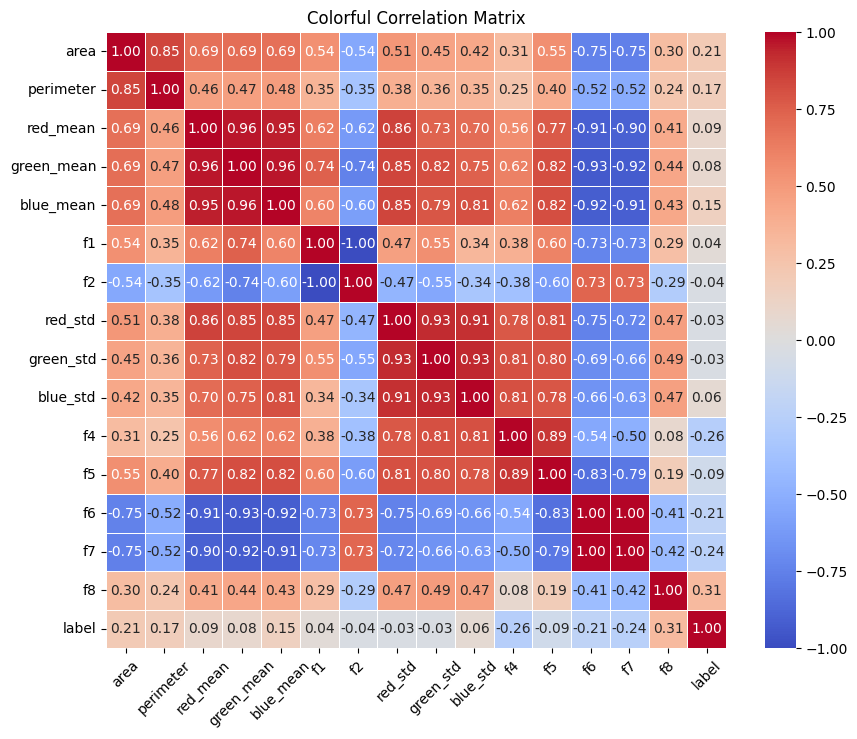

In [12]:
# Set the figure size for the heatmap
plt.figure(figsize=(10, 8))

# Create a heatmap with colorful style
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customize plot labels and title
plt.title('Colorful Correlation Matrix')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)   # Keep y-axis labels horizontal

# Display the heatmap
plt.show()


In [14]:
correlation_matrix = raw_data.corr()

# Convert correlation matrix to a list format
correlation_list = correlation_matrix.unstack().sort_values(ascending=False)

# Display correlation list
print("Pairwise Correlation List:")
print(correlation_list)

Pairwise Correlation List:
area        area          1.000000
perimeter   perimeter     1.000000
f8          f8            1.000000
f7          f7            1.000000
f6          f6            1.000000
                            ...   
f7          green_mean   -0.921881
f6          green_mean   -0.932213
green_mean  f6           -0.932213
f1          f2           -1.000000
f2          f1           -1.000000
Length: 256, dtype: float64


In [13]:
cleaned_data = raw_data.drop(['red_mean','f6','f1'],axis = 1, inplace=False)

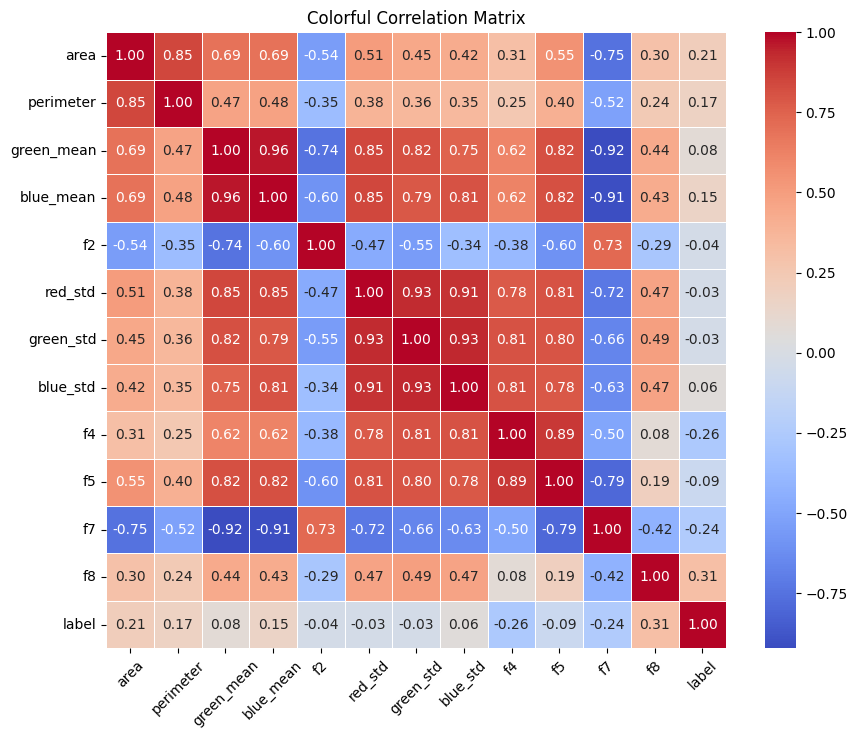

In [16]:
correlation_matrix = cleaned_data.corr()
# Set the figure size for the heatmap
plt.figure(figsize=(10, 8))

# Create a heatmap with colorful style
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Customize plot labels and title
plt.title('Colorful Correlation Matrix')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)   # Keep y-axis labels horizontal

# Display the heatmap
plt.show()


In [14]:
raw_data.shape

(5624, 16)

In [15]:
cleaned_data.shape

(5624, 13)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold 


In [27]:
df = cleaned_data.reset_index()

In [28]:
X = df.drop(['index','label'],axis = 1, inplace=False)
y = df['label']
print(X.shape)
print(y.shape)

(5624, 12)
(5624,)


In [35]:
X

,area,perimeter,green_mean,blue_mean,f2,red_std,green_std,blue_std,f4,f5,f7,f8
0,36474.5,813.109733,59.307648,44.181412,0.47,46.320815,61.767100,50.444602,3610.892186,64.356707,1.722729,3.430396
1,36351.0,837.695520,59.060135,44.010849,0.47,46.426011,61.979119,50.641852,3910.298188,67.945631,1.729057,3.387626
2,36321.5,813.938159,58.898544,43.798203,0.47,46.357759,61.993024,50.527950,3974.323395,68.466235,1.731911,3.377332
3,36474.5,813.109733,59.305542,44.181412,0.47,46.318668,61.767572,50.444666,3610.940066,64.357873,1.722729,3.430391
4,129.5,47.556349,24.742447,19.929443,0.78,39.205569,46.836955,42.953022,2236.038626,34.500579,2.734300,3.433747
...,...,...,...,...,...,...,...,...,...,...,...,...
5619,38547.0,860.156416,69.484283,61.218430,0.57,51.124322,64.201756,58.238985,2771.748201,54.346112,1.602244,3.621733
5620,38547.0,860.156416,69.484268,61.217728,0.57,51.125364,64.202710,58.238223,2771.771868,54.345437,1.602244,3.621729
5621,28591.0,1002.984842,27.968018,28.444748,0.86,32.470542,40.789609,40.909272,1515.776631,34.564354,2.199039,3.515169
5622,28593.0,1002.984843,27.970352,28.448990,0.86,32.468568,40.787746,40.909737,1515.799571,34.571873,2.198917,3.515165


In [36]:
y

0       0
1       0
2       0
3       0
4       0
       ..
5619    2
5620    2
5621    2
5622    2
5623    2
Name: label, Length: 5624, dtype: int64

In [38]:
import pandas as pd
import numpy as np
from collections import Counter

# Define your custom RandomForest and DecisionTree classes
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if self.n_features is None else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_features, replace=False)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y, feat_idxs)

        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feature, best_threshold, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.where(X_column <= split_thresh)[0]
        right_idxs = np.where(X_column > split_thresh)[0]
        return left_idxs, right_idxs

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                                min_samples_split=self.min_samples_split,
                                n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = np.swapaxes(predictions, 0, 1)
        return np.array([self._most_common_label(pred) for pred in predictions])


# Step 1: Load the dataset from a CSV file



# Parameters for k-fold cross-validation
k = 5
random_state = 9

# Get the number of samples
n_samples = X.shape[0]

# Split data into k folds
def k_fold_split(n_samples, n_splits, random_state=None):
    indices = np.arange(n_samples)
    np.random.seed(random_state)
    np.random.shuffle(indices)
    fold_size = n_samples // n_splits
    folds = []
    
    for i in range(n_splits):
        test_start = i * fold_size
        test_end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
        test_indices = indices[test_start:test_end]
        train_indices = np.concatenate([indices[:test_start], indices[test_end:]])
        folds.append((train_indices, test_indices))
    
    return folds

# Initialize your RandomForest model
rf_model = RandomForest(n_trees=50, max_depth=10, min_samples_split=2, n_features=None)

# Split data into k


In [39]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
  # Import your custom RandomForest class


# Step 3: Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and train the RandomForest model
rf_model = RandomForest(n_trees=50, max_depth=10, min_samples_split=2, n_features=None)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate model accuracy
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")


KeyError: "None of [Index([4175, 1530, 1422, 1243, 2077, 3023, 4240, 1850, 3088, 2294,\n       ...\n       1808,  688,  373,  367,  505, 2417, 4324, 2104, 2169, 3101],\n      dtype='int32', length=4499)] are in the [columns]"

In [37]:
n_samples = X.shape[0]

In [29]:
k = 5
kf = KFold(n_splits=k, random_state=9, shuffle = True)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
    model = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)            # classification
    acc = accuracy_score(pred_values , y_test)     # Classification

    #acc = model.score(X_test,y_test)                # Regression
    
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('Score of each fold - {}'.format(acc_score))
print('Avg Score : {}'.format(avg_acc_score))

Score of each fold - [0.9608888888888889, 0.9528888888888889, 0.9653333333333334, 0.9635555555555556, 0.9635231316725978]
Avg Score : 0.961237959667853


C:\Users\Manish Yadav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


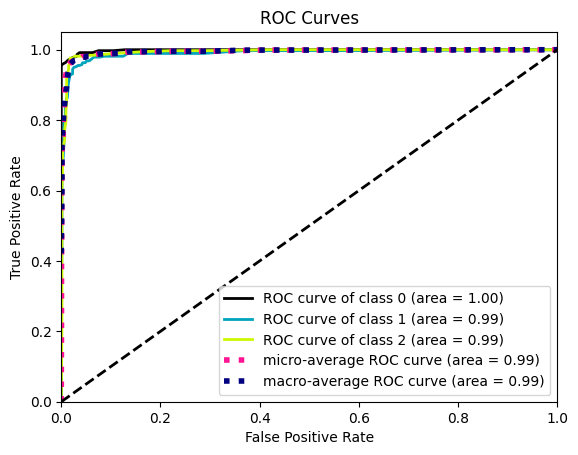

In [30]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_test
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)



plt.show()

In [31]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)

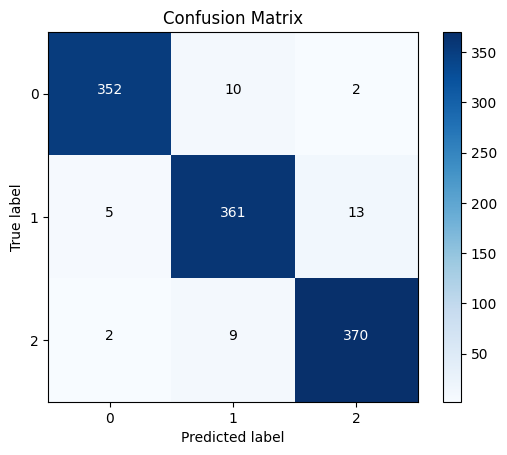

In [32]:
cm = confusion_matrix(y_test, y_pred)
labels = ['0', '1', '2']

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Add numbers inside the plot
thresh = cm.max() / 2.  # Threshold for using different colors
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
from sklearn.metrics import classification_report

# Assuming y_test and y_pred are your true labels and predicted labels respectively
# The labels argument should be a list of unique labels present in y_test and y_pred
labels = ['0','1','2']

# Generate classification report
print(classification_report(y_test, y_pred, labels=labels))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       364
           1       0.95      0.95      0.95       379
           2       0.96      0.97      0.97       381

   micro avg       0.96      0.96      0.96      1124
   macro avg       0.96      0.96      0.96      1124
weighted avg       0.96      0.96      0.96      1124



C:\Users\Manish Yadav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\Manish Yadav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\Manish Yadav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\lib\arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\Manish Yadav\AppData\Local\P

In [31]:
from sklearn.ensemble import RandomForestClassifier
lm = RandomForestClassifier(random_state = 50,n_estimators = 50,max_samples = 0.7)
lm.fit(X,y)
print('Training Score: ',lm.score(X,y))

Training Score:  0.9987553342816501


In [32]:
lm.feature_importances_

array([0.08363599, 0.07704096, 0.05820369, 0.06576188, 0.13276667,
       0.05823107, 0.1006394 , 0.09629473, 0.11321218, 0.05881356,
       0.08806116, 0.06733872])

In [33]:
import pickle

In [34]:
filename = filename = 'C:/New Volume/project 2k24/project2k24/deployment/models/Potato_Model_V2.sav'
with open(filename, 'wb') as file:
    pickle.dump(lm, file)

print(f"Model saved successfully to '{filename}'")

Model saved successfully to 'C:/New Volume/project 2k24/project2k24/deployment/models/Potato_Model_V2.sav'
